# imports

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV

# read csv file

In [43]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1')
df.columns = ['sentiment','id','date','query','user','text']
df['text']

0          is upset that he can't update his Facebook by ...
1          @Kenichan I dived many times for the ball. Man...
2            my whole body feels itchy and like its on fire 
3          @nationwideclass no, it's not behaving at all....
4                              @Kwesidei not the whole crew 
                                 ...                        
1048567             My GrandMa is making Dinenr with my Mum 
1048568    Mid-morning snack time... A bowl of cheese noo...
1048569    @ShaDeLa same here  say it like from the Termi...
1048570               @DestinyHope92 im great thaanks  wbuu?
1048571                 cant wait til her date this weekend 
Name: text, Length: 1048572, dtype: object

## EDA

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   id         1048572 non-null  int64 
 2   date       1048572 non-null  object
 3   query      1048572 non-null  object
 4   user       1048572 non-null  object
 5   text       1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [45]:
df.describe()

,sentiment,id
count,1.048572e+06,1.048572e+06
mean,9.482458e-01,1.976168e+09
std,1.701122e+00,2.300567e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990870e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [46]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [47]:
df['sentiment'] = df['sentiment'].replace({4:1})

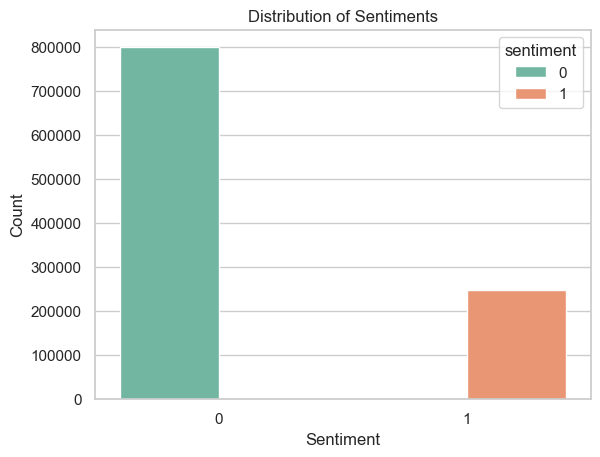

In [48]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [49]:
df['text'].isnull().sum()

0

In [50]:
df = df.drop_duplicates('text')

## Preprocessing

In [51]:

stuff_to_be_removed = list(punctuation)

def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          # converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       # removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                          # removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text)                                         # removing other symbols like ^ except '
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    
    return text1 

In [52]:
data_cleaned = pd.DataFrame()
df['text'] = df['text'].apply(textprocessing)
df['text'].head()

0    is upset that he can t updat his facebook by t...
1    kenichan i dive mani time for the ball manag t...
2         my whole bodi feel itchi and like it on fire
3    nationwideclass no it s not behav at all i m m...
4                          kwesidei not the whole crew
Name: text, dtype: object

In [53]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,is upset that he can t updat his facebook by t...
1,0,kenichan i dive mani time for the ball manag t...
2,0,my whole bodi feel itchi and like it on fire
3,0,nationwideclass no it s not behav at all i m m...
4,0,kwesidei not the whole crew


## Visualizations

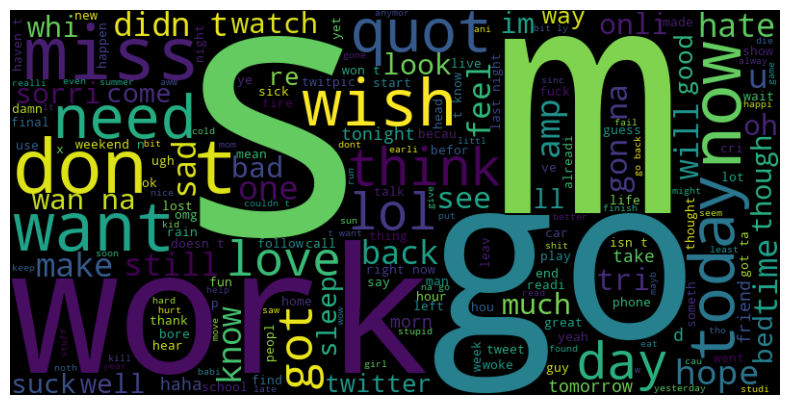

In [54]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

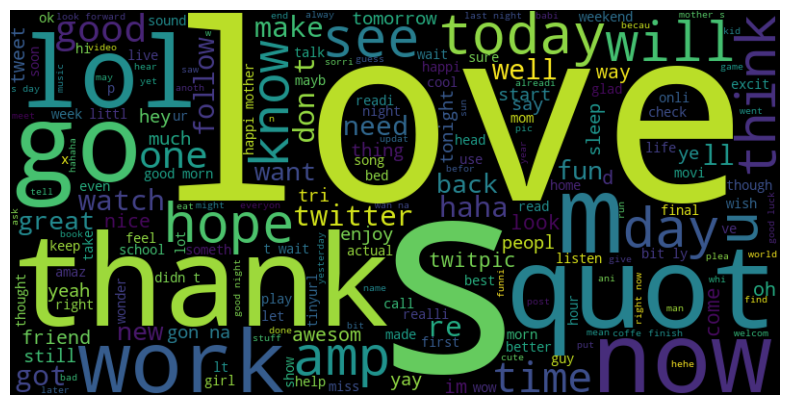

In [55]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Scaling

In [56]:
x = df['text']
y = df['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(x)

# ngrams reduce accuracy of the model

In [57]:

X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

## SVM with PCA

In [58]:



n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_svm_pca = svd.fit_transform(X_train_svm)
X_validation_svm_pca = svd.transform(X_validation_svm)
X_test_svm_pca = svd.transform(X_test_svm)






In [59]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_svm_pca, y_train_svm)


y_pred_validation_svm = svm_model.predict(X_validation_svm_pca)
accuracy_validation_svm = accuracy_score(y_validation_svm, y_pred_validation_svm)
print(f"Accuracy on the validation set: {accuracy_validation_svm}")


y_pred_test_svm = svm_model.predict(X_test_svm_pca)
accuracy_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print(f"Accuracy on the test set: {accuracy_test_svm}")

Accuracy on the validation set: 0.7913524642903101
Accuracy on the test set: 0.7923304594003345


In [60]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'C': [0.1, 1, 10, 100]}  # You can adjust other hyperparameters as well

# # Create a grid search
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(train_vectors, train_labels)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# # Get the best model
# best_model = grid_search.best_estimator_

## SVM without PCA

In [ ]:


classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

In [ ]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))

In [ ]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

In [ ]:
svm_predictions_validation= classifier.predict(X_validation_svm)

accuracy = accuracy_score(y_validation_svm, svm_predictions_validation)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_validation_svm, svm_predictions_validation))

## Downsampling

In [ ]:
## majority class 0
df_majority_knn = df[df['sentiment']==0]
## minority class 1
df_minority_knn = df[df['sentiment']==1]

df_majority_downsampled_knn = resample(df_majority_knn, replace=False, n_samples=len(df_minority_knn)//5,random_state=134)

df_minority_downsampled_knn = resample(df_minority_knn, replace=False,n_samples=len(df_minority_knn)//5,random_state=134)


In [ ]:
df = pd.concat([df_majority_downsampled_knn, df_minority_downsampled_knn])

x = df['text']
y = df['sentiment']


vectorizer2 = tf()
vectors = vectorizer2.fit_transform(x)

vectors.shape


In [ ]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [ ]:
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_knn, X_test_knn, y_validation_knn, y_test_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.5, random_state=52)

## KNN with PCA

In [ ]:

n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_knn_pca = svd.fit_transform(X_train_knn)
X_validation_knn_pca = svd.transform(X_validation_knn)
X_test_knn_pca = svd.transform(X_test_knn)


knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train_knn_pca, y_train_knn)


y_pred_validation_knn = knn_model.predict(X_validation_knn_pca)
accuracy_validation_knn = accuracy_score(y_validation_knn, y_pred_validation_knn)
print(f"Accuracy on the validation set: {accuracy_validation_knn}")

y_pred_test_knn = knn_model.predict(X_test_knn_pca)
accuracy_test_knn = accuracy_score(y_test_knn, y_pred_test_knn)
print(f"Accuracy on the test set: {accuracy_test_knn}")

In [ ]:
l = int(np.sqrt(len(x)))
print(l)

## KNN without PCA

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=l)  # You can experiment with different values of k
knn_classifier.fit(X_train_knn, y_train_knn)


knn_predictions_train =knn_classifier.predict(X_train_knn) 
knn_accuracy = accuracy_score(y_train_knn, knn_predictions_train)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_train_knn, knn_predictions_train))

In [ ]:
knn_prediction_test = knn_classifier.predict(X_test_knn) 
knn_accuracy = accuracy_score(y_test_knn, knn_prediction_test)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_test_knn, knn_prediction_test))

In [ ]:
knn_predictions_validation =knn_classifier.predict(X_validation_knn) 
knn_accuracy = accuracy_score(y_validation_knn, knn_predictions_validation)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")

print(classification_report(y_validation_knn, knn_predictions_validation))

In [ ]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=None)
    disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Training Confusion Matrix ')

    
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=None)
    disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

## SVM ACC

In [ ]:
metrics(y_train_svm,svm_predictions_train ,y_test_svm,svm_prediction_test)

## KNN ACC

In [ ]:
metrics(y_train_knn,knn_predictions_train ,y_test_knn,knn_prediction_test)

## ROC Curve of KNN, SVM

In [ ]:
def plot_roc_curve(fpr, tpr, label, title):
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, auc(fpr, tpr)))


plt.figure(figsize=(10, 6))

# KNN
knn_probs = knn_classifier.predict_proba(X_test_knn)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test_knn, knn_probs)
plot_roc_curve(knn_fpr, knn_tpr, 'KNN', 'ROC Curve - KNN')

# SVM
svm_probs = classifier.predict_proba(X_test_svm)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_svm, svm_probs)
plot_roc_curve(svm_fpr, svm_tpr, 'SVM', 'ROC Curve - SVM')

# Plotting diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## Conclusion

|Model|Training Accuracy|Testing Accuracy|Validation Accuracy
|---|---|---|--|
|SVM|91%|85%|85%|
|KNN|75%|74%|74%|

In [ ]:
new_text = "i happy to hear that"
new_text_vector = vectorizer.transform([new_text])

prediction = classifier.predict(new_text_vector)

if prediction[0] == 1:
    print("positve user comment")
else:
    print("negative user comment")

